In [1]:
import copy
import glob
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import matplotlib.image as mpimg
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
from py2tex import py2tex

In [6]:
import trove
import trove.config_parser

# Load Data

In [7]:
pm = {
    'sims_to_plot': [ [ 'm12i_md', 'm12b_md', ], [ 'm12c_md', 'm11d_md' ] ],
}

In [8]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
cp = trove.config_parser.ConfigParser( config_fp )
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
    **pm
)

In [9]:
sims_to_plot = pm['sims_to_plot']

In [10]:
sims_to_plot_flat = sims_to_plot[0] + sims_to_plot[1]

In [11]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [12]:
h_param = .702

In [13]:
mvir = verdict.Dict({})
mstar = verdict.Dict({})
rgal = verdict.Dict({})
rvir = verdict.Dict({})
for key in tqdm.tqdm( cp.variations ):
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600] )[0]/h_param
    mstar[key] = h_data.get_mt_data( 'M_star', snums=[600] )[0]/h_param
    
    rstar_z0 = h_data.get_mt_data( 'Rstar0.5', snums=[600] )/h_param
    rgal[key] = 4. * rstar_z0
    rvir[key] = h_data.get_mt_data( 'Rvir', snums=[600] )/h_param

100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


# Edge-on Images

In [14]:
# Set plot parameters
x_lim_rgal = [ -2, 2 ]
y_lim_rgal = [ -1, 1 ]
panel_width = 8.

In [15]:
# Derived plot parameters
aspect = ( y_lim_rgal[1] - y_lim_rgal[0] ) / ( x_lim_rgal[1] - x_lim_rgal[0] )
n_rows = len( sims_to_plot )
n_cols = len( sims_to_plot[0] )

# Somehow the aspect isn't quite right. This fixes that.
correction_factor = 1.025

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/stars.pdf


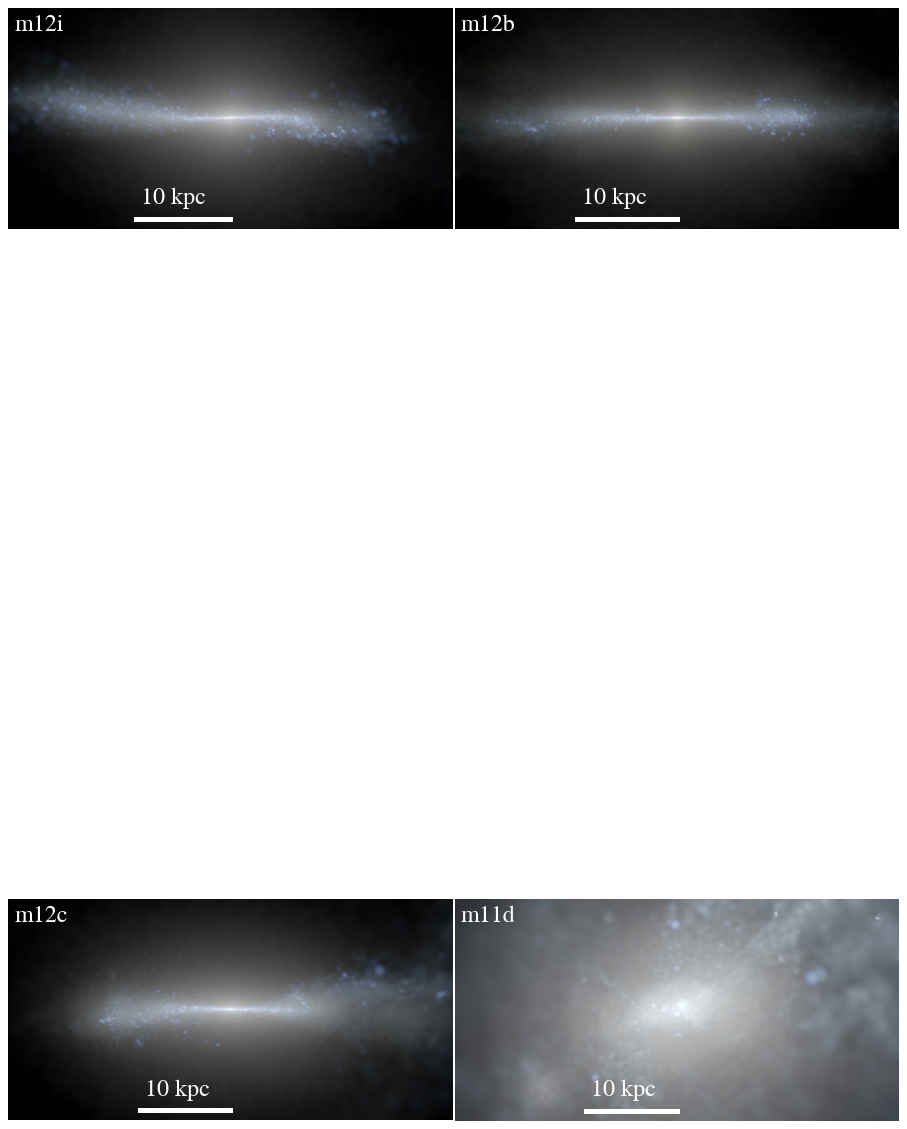

In [26]:
fig = plt.figure( figsize=(panel_width*n_rows, panel_width*aspect*correction_factor*n_cols), facecolor='w' )
fig.subplots_adjust( hspace=0.0001, wspace=0.0001 )
ax_dict = fig.subplot_mosaic( sims_to_plot )

for k, row in enumerate( sims_to_plot ):
    
    for j, sim in enumerate( row ):

        ax = ax_dict[sim]
        
        # Image dir
        data_dir = os.path.join( pm['root_data_dir'], sim )
        image_dir = os.path.join( data_dir, 'firestudio', 'Plots', 'GasTwoColour' )

        # Image filepath
        image_glob = os.path.join( image_dir, 'edge_on*.png' )
        image_fps = glob.glob( image_glob )
        assert len( image_fps ) == 1
        image_fp = image_fps[0]

        # Metadata filepath
        metadata_glob = os.path.join( image_dir, 'edge_on*hdf5' )
        metadata_fps = glob.glob( metadata_glob )
        assert len( metadata_fps ) == 1
        metadata_fp = metadata_fps[0]

        # Load image and metadata
        img = mpimg.imread( image_fp )
        metadata = verdict.Dict.from_hdf5( metadata_fp )

        # Rotate image and set up xs and ys
        img = np.rot90( img )
        xs = np.linspace( metadata['Ymin'], metadata['Ymax'], img.shape[1] )
        ys = np.linspace( metadata['Xmin'], metadata['Xmax'], img.shape[0] )

        # Limits in physical kpc
        x_lim = rgal[key] * np.array( x_lim_rgal )
        y_lim = rgal[key] * np.array( y_lim_rgal )

        # Select only part of the image
        in_bound_x = ( xs > x_lim[0] )& ( xs < x_lim[1] )
        in_bound_y = ( ys > y_lim[0] )& ( ys < y_lim[1] )
        img = img[:,in_bound_x][in_bound_y,:]
        xs = xs[in_bound_x]
        ys = ys[in_bound_y]

        # Reset limit to avoid weird whitespace
        x_lim = [ xs[0], xs[-1] ]
        y_lim = [ ys[0], ys[-1] ]

        extent = [ xs[0], xs[-1], ys[0], ys[-1] ] 
        
        ax.imshow(
            img,
            extent = extent,
            aspect = 'equal',
        )
        
        
        # Change colors
        ax.set_facecolor( 'k' )
        plt.setp( ax.spines.values(), color='w' )
        [m.set_linewidth(2) for m in ax.spines.values()]
                
        # Limits
        ax.set_xlim( x_lim )
        ax.set_ylim( y_lim )
        
        # Ticks
        ax.tick_params( 
            'both', 
            left = False,
            labelleft = False,
            bottom = False,
            labelbottom = False,
        )
        
        # Scale bar
        def round_down(num, divisor):
            return num - (num%divisor)
        size = int( round_down( rgal[key], 10 ) )
        if np.isclose( size, 0. ):
            size = 10.
        xy = ( -size, 0.9 * y_lim[0] )
        ax.plot(
            xy[0] + np.array([ 0., size ]),
            [ xy[1], xy[1] ],
            linewidth = 5,
            color = 'w',
        )
        ax.annotate(
            text = '{:.2g} kpc'.format( size ),
            xy = xy,
            xycoords = 'data',
            xytext = ( 5, 10 ),
            textcoords = 'offset points',
            va = 'bottom',
            ha = 'left',
            color = 'w',
            fontsize = 24,
        )
        
        # Sim name
        ax.annotate(
            text = sim.split( '_' )[0],
            xy = ( 0, 1),
            xycoords = 'axes fraction',
            xytext = ( 7, -7 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
            color = 'w',
            fontsize = 24,
        )
        
plotting.save_fig(
    out_dir = pm['figure_dir'],
    save_file = 'stars.pdf',
    fig = fig,
)

# $R_{T = 10^5 {\rm K}}$ Distributions

In [17]:
qual_cmap = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
cmap = palettable.matplotlib.Viridis_20.mpl_colormap
norm = matplotlib.colors.Normalize( vmin=data['thin_disk_fraction'].keymin()[1], vmax=data['thin_disk_fraction'].keymax()[1] )

## One Panel

In [18]:
linestyles = {
    'm11': '--',
    'm12': '-',
}

In [19]:
label_locs = {
    'm12i_md': ( rgal['m12c_md'] / rvir['m12c_md'], 0.01 ),
    'm12b_md': ( rgal['m12c_md'] / rvir['m12c_md'], 0.007 ),
    'm12c_md': ( rgal['m12c_md'] / rvir['m12c_md'], 0.004 ),
    'm11d_md': ( rgal['m11d_md'] / rvir['m11d_md'], 0.04 ),
}

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/R1e5K.pdf


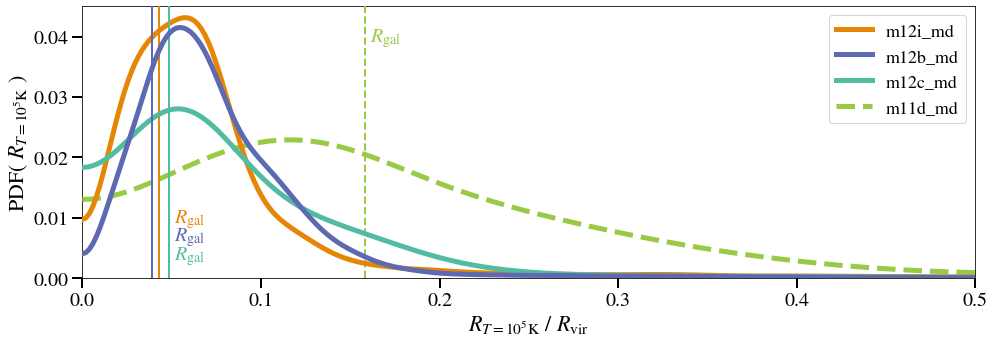

In [25]:
scale = 1.
fig = plt.figure( figsize=(16,5), facecolor='w' )
ax = plt.gca()

for i, sim in enumerate( sims_to_plot_flat ):
    ax.plot(
        data['R1e5K']['points'][sim] / rvir[sim],
        data['R1e5K']['pdf'][sim],
        linewidth = 5,
        c = qual_cmap[i],
#         c = cmap( norm( data['thin_disk_fraction'][sim] ) ),
        label = sim,
        zorder = np.log10( mvir[sim] ),
        linestyle = linestyles[sim[:3]]
    )
    
    # Lines for the galaxy radius
    ax.axvline(
        rgal[sim] / rvir[sim],
        linewidth = 2,
        c = qual_cmap[i],
#         c = cmap( norm( data['thin_disk_fraction'][sim] ) ),
        linestyle = linestyles[sim[:3]],
        zorder = np.log10( mvir[sim] ),
    )

    # Annotate the lines
    if sim in label_locs:
        ax.annotate(
            text = r'$R_{\rm gal}$',
            xy = label_locs[sim],
            xytext = ( 5, -5 ),
            xycoords = 'data',
            textcoords = 'offset points',
            fontsize = 20,
            color = qual_cmap[i],
        )

    
ax.legend(
    prop = { 'size': 18 },
)
    
ax.set_xlim( 0, 0.5 )
ax.set_ylim( 0, 0.045 )

ax.set_xlabel( r'$R_{T=10^5 {\rm K}}$ / $R_{\rm vir}$', fontsize=22 )
ax.set_ylabel( r'PDF( $R_{T=10^5 {\rm K}}$ )', fontsize=22 )

plotting.save_fig(
    out_dir = pm['figure_dir'],
    save_file = 'R1e5K.pdf',
    fig = fig,
)

## Multi Panel

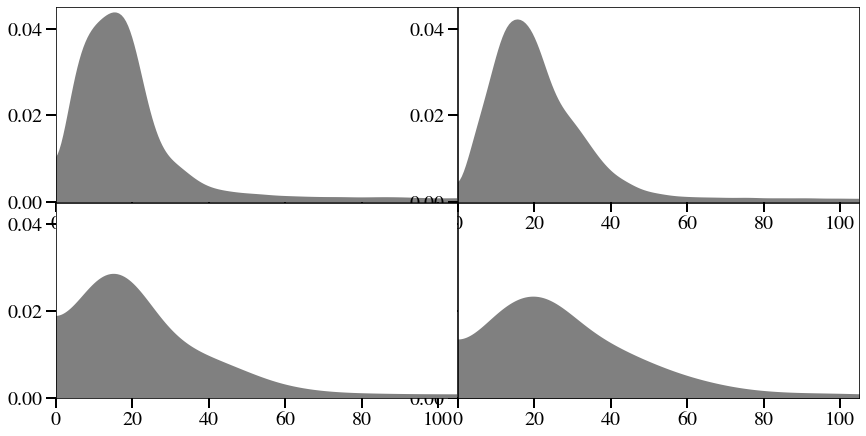

In [21]:
scale = 1.2

n_rows = len( sims_to_plot )
n_cols = len( sims_to_plot[0] )

fig = plt.figure( figsize=(6. * n_cols * scale, 3. * n_rows * scale), facecolor='w', )
fig.subplots_adjust( hspace=0.001, wspace=0.001 )
# main_ax = plt.gca()
ax_dict = fig.subplot_mosaic( sims_to_plot )

for k, row in enumerate( sims_to_plot ):
    
    for j, sim in enumerate( row ):

        ax = ax_dict[sim]
        
        r_pdf = data['R1e5K']['pdf'][sim]
        r_points = data['R1e5K']['points'][sim]
        
#         ax.plot(
#             data['R1e5K']['points'][sim],
#             data['R1e5K']['pdf'][sim],
#             linewidth = 5,
#             c = qual_cmap[i],
#     #         c = cmap( norm( data['thin_disk_fraction'][sim] ) ),
#             label = sim,
#             zorder = np.log10( mvir[sim] ),
#             linestyle = linestyles[sim[:3]]
#         )

        ax.fill_between(
            r_points,
            r_pdf,
            color = '0.5',
            linewidth = 5,
        )

        ax.set_xlim( 0, 105 ),
        ax.set_ylim( 0, 0.045 )

# Angular Distributions

## Vertical

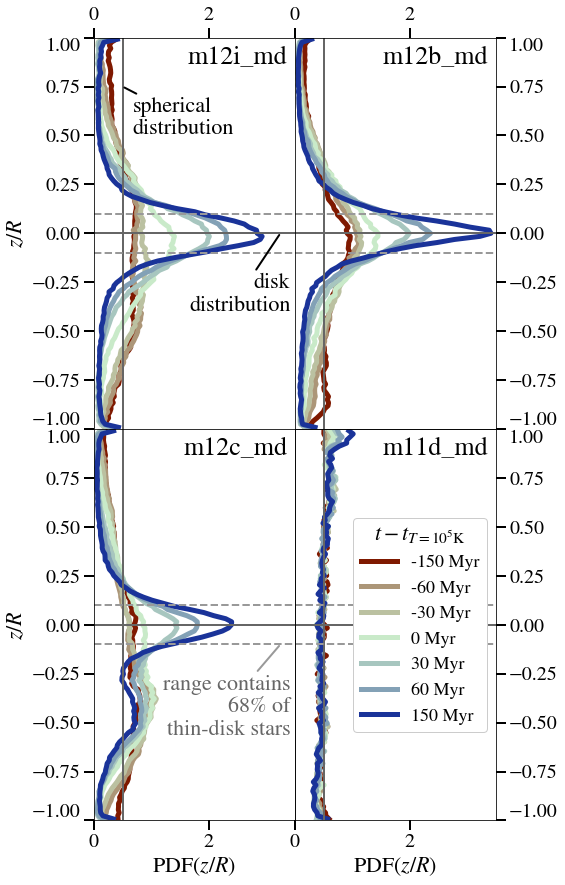

In [22]:
aspect = 2.
scale = 1.2

n_rows = len( sims_to_plot )
n_cols = len( sims_to_plot[0] )

fig = plt.figure( figsize=(3. * n_cols * scale, 6. * n_rows * scale), facecolor='w', )
fig.subplots_adjust( hspace=0.001, wspace=0.001 )
# main_ax = plt.gca()
ax_dict = fig.subplot_mosaic( sims_to_plot )

for k, row in enumerate( sims_to_plot ):

    for j, sim in enumerate( row ):

        ax = ax_dict[sim]

        pdfs = data['cosphi']['hist'][sim]
        centers = data['cosphi']['points'][sim]
        t_t1e5_centers = data['cosphi']['t_t1e5_centers'][sim]
        z_max = t_t1e5_centers.max()
        z_min = t_t1e5_centers.min()

        for i, pdf in enumerate( pdfs ):

            z_width = z_max - z_min
            color_value = ( t_t1e5_centers[i] - z_min )/z_width
            color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

            if np.isclose( t_t1e5_centers[i], 0. ):
                t_t1e5_centers[i] = 0
    #             label = (
    #                 r'$t - t_{T=10^5 {\rm K}}$ =' +
    #                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
    #                 r' Myr'
    #             )
            label = (
                '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
                r' Myr'
            )

            line = ax.plot(
                pdf,
                centers,
                linewidth = 5,
                color = color,
                label = label,
        #             zorder = 10 - i,
            )

        ax.tick_params(
            axis = 'both',
            top = ax.is_first_row(),
            labeltop = ax.is_first_row(),
            bottom = ax.is_last_row(),
            labelbottom = ax.is_last_row(),
            left = ax.is_first_col(),
            labelleft = ax.is_first_col(),
            right = ax.is_last_col(),
            labelright = ax.is_last_col(),
        )

        # Distribution curves
        ax.axvline(
            0.5,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
#         ax.plot(
#             0.5 * np.sin( np.arccos( centers ) ),
#             np.arccos( centers ),
#         )
        ax.axhline(
            0.,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
        
        # Comparison curves
        ax.axhline(
            pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        ax.axhline(
            -pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        if ax.is_last_row() and ax.is_first_col():
            ax.annotate(
                text = 'range contains\n68% of\nthin-disk stars',
                xy = ( 3.25, -pm['disk_costheta'] ),
                xycoords = 'data',
                xytext = ( 10, -30 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 22,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color': pm['lighter_background_linecolor'],
                },
                color = pm['background_linecolor'],
            )
        
        # Sim name label
        ax.annotate(
            text = sim,
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -7, -7 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 26,
        )
        
        ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
        ax.get_yticklabels()[-3].set_verticalalignment( 'top' )

        if ax.is_first_row() and ax.is_first_col():
            # line labels
            ax.annotate(
                text = 'spherical\ndistribution',
                xy = ( 0.5, 0.75 ),
                xycoords = 'data',
                xytext = ( 10, -10 ),
                textcoords = 'offset points',
                ha = 'left',
                va = 'top',
                fontsize = 22,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                }
            )
            ax.annotate(
                text = 'disk\ndistribution',
                xy = ( 3.25, 0 ),
                xycoords = 'data',
                xytext = ( 10, -40 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 22,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                }
            )

        if ax.is_last_row() and ax.is_last_col():
            ax.legend(
                prop={'size': 18},
                loc = 'center right',
                framealpha = 1,
                title = r'$t - t_{T=10^5 {\rm K}}$',
                title_fontsize = 22,
            )

        ax.set_xlim( 0, 3.5 )
        ax.set_ylim( -1., 1. )
#         ax.set_ylim( 0., np.pi )

        if ax.is_last_row():
            ax.set_xlabel( r'PDF$(z/R)$', fontsize=22 )

        if ax.is_first_col():
            ax.set_ylabel( r'$z/R$', fontsize=22 )
            
# plotting.save_fig(
#     out_dir = pm['figure_dir'],
#     save_file = 'theta_vs_t.pdf',
#     fig = fig,
# )

## Horizontal

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/theta_vs_t.pdf


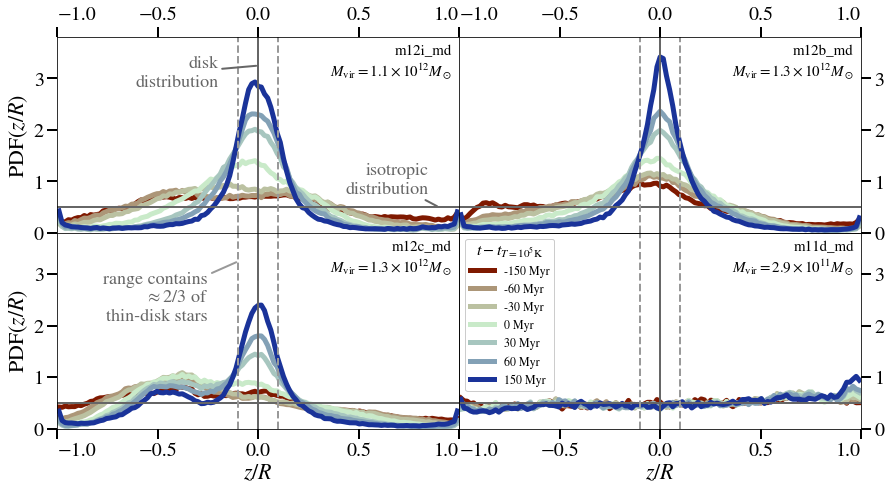

In [23]:
scale = 1.2

n_rows = len( sims_to_plot )
n_cols = len( sims_to_plot[0] )

fig = plt.figure( figsize=(6. * n_cols * scale, 3. * n_rows * scale), facecolor='w', )
fig.subplots_adjust( hspace=0.001, wspace=0.001 )
# main_ax = plt.gca()
ax_dict = fig.subplot_mosaic( sims_to_plot )

for k, row in enumerate( sims_to_plot ):

    for j, sim in enumerate( row ):

        ax = ax_dict[sim]

        pdfs = data['cosphi']['hist'][sim]
        centers = data['cosphi']['points'][sim]
        t_t1e5_centers = data['cosphi']['t_t1e5_centers'][sim]
        z_max = t_t1e5_centers.max()
        z_min = t_t1e5_centers.min()

        for i, pdf in enumerate( pdfs ):

            z_width = z_max - z_min
            color_value = ( t_t1e5_centers[i] - z_min )/z_width
            color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

            if np.isclose( t_t1e5_centers[i], 0. ):
                t_t1e5_centers[i] = 0
    #             label = (
    #                 r'$t - t_{T=10^5 {\rm K}}$ =' +
    #                 ' {:.3g}'.format( t_tphase_centers[i]*1e3 ) +
    #                 r' Myr'
    #             )
            label = (
                '{:.3g}'.format( t_t1e5_centers[i]*1e3 ) +
                r' Myr'
            )

            line = ax.plot(
                centers,
                pdf,
                linewidth = 5,
                color = color,
                label = label,
        #             zorder = 10 - i,
            )

        ax.tick_params(
            axis = 'both',
            top = ax.is_first_row(),
            labeltop = ax.is_first_row(),
            bottom = ax.is_last_row(),
            labelbottom = ax.is_last_row(),
            left = ax.is_first_col(),
            labelleft = ax.is_first_col(),
            right = ax.is_last_col(),
            labelright = ax.is_last_col(),
        )

        # Distribution curves
        ax.axhline(
            0.5,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
#         ax.plot(
#             0.5 * np.sin( np.arccos( centers ) ),
#             np.arccos( centers ),
#         )
        ax.axvline(
            0.,
            color = pm['background_linecolor'],
            linestyle = '-',
            linewidth = 2,
        )
        
        # Comparison curves
        ax.axvline(
            pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        ax.axvline(
            -pm['disk_costheta'],
            color = pm['lighter_background_linecolor'],
            linestyle = '--',
            linewidth = 2,
        )
        if ax.is_last_row() and ax.is_first_col():
            ax.annotate(
                text = 'range contains\n' + r'$\approx 2/3$' + ' of\nthin-disk stars',
                xy = ( -pm['disk_costheta'], 3.25 ),
                xycoords = 'data',
                xytext = ( -30, -10 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 18,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color': pm['lighter_background_linecolor'],
                },
                color = pm['background_linecolor'],
            )
        
        # Sim name label
        sim_label = sim
        sim_label += '\n' + r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( mvir[sim], 2 ) +  r'M_\odot$'
#         sim_label += '\n' + r'$f_{\rm thin\,disk,\,young}$ = ' + '{:.2g}'.format( data['thin_disk_fraction_recent'][sim] )
        ax.annotate(
            text = sim_label,
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -7, -7 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 15,
        )
        
        ax.get_xticklabels()[0].set_horizontalalignment( 'left' )
        ax.get_xticklabels()[-3].set_horizontalalignment( 'right' )

        if ax.is_first_row() and ax.is_first_col():
            # line labels
            ax.annotate(
                text = 'isotropic\ndistribution',
                xy = ( 0.9, 0.5 ),
                xycoords = 'data',
                xytext = ( -10, 10 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'bottom',
                fontsize = 18,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color': pm['background_linecolor'],
                },
                color = pm['background_linecolor'],
            )
            ax.annotate(
                text = 'disk\ndistribution',
                xy = ( 0, 3.25 ),
                xycoords = 'data',
                xytext = ( -40, 10 ),
                textcoords = 'offset points',
                ha = 'right',
                va = 'top',
                fontsize = 18,
                arrowprops = {
                    'arrowstyle': '-',
                    'lw': 2,
                    'color':  pm['background_linecolor'],
                },
                color = pm['background_linecolor'],
            )

        if ax.is_last_row() and ax.is_last_col():
            ax.legend(
                prop={'size': 12},
                loc = 'upper left',
                framealpha = 1,
                title = r'$t - t_{T=10^5 {\rm K}}$',
                title_fontsize = 16,
            )

        ax.set_xlim( -1., 1. )
        ax.set_ylim( 0, 3.8 )
#         ax.set_ylim( 0., np.pi )

        if ax.is_last_row():
            ax.set_xlabel( r'$z/R$', fontsize=22 )

        if ax.is_first_col():
            ax.set_ylabel( r'PDF$(z/R)$', fontsize=22 )
            
plotting.save_fig(
    out_dir = pm['figure_dir'],
    save_file = 'theta_vs_t.pdf',
    fig = fig,
)